# Cicero

Analysing co-accessibility using Cicero.

Tutorial: https://cole-trapnell-lab.github.io/cicero-release/docs_m3

In [75]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)

## Load Data

In [32]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200220_n74838/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  74838 467339

In [196]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 74838     6

,sample,umap.1,umap.2,cluster,barcode,cells
,<fct>,<dbl>,<dbl>,<int>,<list>,<chr>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,AAACAACGACGATTAC,D0_AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,AAACAACGACTCACGG,D0_AAACAACGACTCACGG
D0_AAACAACGAGCGCACT,D0,6.080648,-8.114705,2,AAACAACGAGCGCACT,D0_AAACAACGAGCGCACT
D0_AAACAACGATGGAACG,D0,3.584474,-7.276754,1,AAACAACGATGGAACG,D0_AAACAACGATGGAACG
D0_AAACACGCTACGCCAC,D0,5.299551,-8.133782,2,AAACACGCTACGCCAC,D0_AAACACGCTACGCCAC


In [197]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 467339      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_16146_16347,chr1,16146,16347,chr1_16146_16347
chr1_51458_51659,chr1,51458,51659,chr1_51458_51659
chr1_51688_52109,chr1,51688,52109,chr1_51688_52109
chr1_180685_181260,chr1,180685,181260,chr1_180685_181260
chr1_181267_181597,chr1,181267,181597,chr1_181267_181597
chr1_184384_184585,chr1,184384,184585,chr1_184384_184585


## Sanity Check

To see if metaData, matrix and regions are well-aligned

In [64]:
pmatRowSums = Matrix::rowSums(pmat)

In [285]:
# region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
region_gr = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [337]:
tmp_regions = regions[,c("chr", "bp1", "bp2")]
colnames(tmp_regions) = c("chr", "start", "end")
norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(GRanges(tmp_regions), region_gr)))])/pmatRowSums

In [338]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)

[1] 0.1766852

[1] 0.003071063

[1] 0

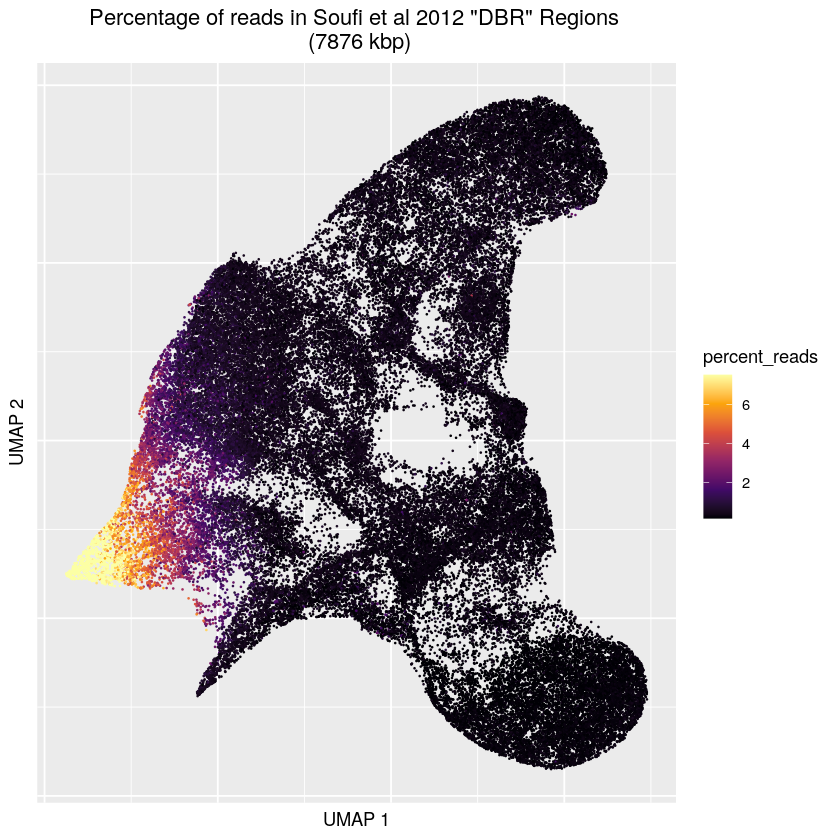

In [339]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Soufi et al 2012 \"DBR\" Regions \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.99)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

## Running Cicero 

In [52]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [84]:
row.names(pmat) <- row.names(metaData)
colnames(pmat) <- row.names(regions)

In [85]:
input_cds <-  new_cell_data_set(t(pmat),  # need to transpose based on tutorial
              cell_metadata = metaData,
              gene_metadata = regions)

Warning message in new_cell_data_set(t(pmat), cell_metadata = metaData, gene_metadata = regions):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [86]:
input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [87]:
umap_df = data.frame(umap_coord1=metaData$umap.1, umap_coord2=metaData$umap.2)
rownames(umap_df) = rownames(metaData)
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_df)

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.0324292495123973
Median shared cells bin-bin: 0



In [88]:
hg38.chrom.sizes = read.table("~/genomes/hg38/hg38.chrom.sizes")
sample_genome <- subset(hg38.chrom.sizes, V1 == "chr2")
sample_genome$V2[1] <- 10000000

In [ ]:
conns <- run_cicero(cicero_cds, hg38.chrom.sizes)

In [207]:
head(conns)

,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr10_100006055_100006360,chr10_99754802_99755053,0.056457562
2,chr10_100006055_100006360,chr10_99758327_99758528,0.000000000
3,chr10_100006055_100006360,chr10_99760437_99760638,-0.002025556
4,chr10_100006055_100006360,chr10_99760911_99761225,-0.003445214
5,chr10_100006055_100006360,chr10_99768435_99769017,0.036989832
6,chr10_100006055_100006360,chr10_99775825_99776218,0.180325292


In [208]:
dim(conns)

[1] 72241474        3

In [226]:
sum(conns$coaccess > 0.5, na.rm=T)

[1] 121268

In [225]:
# write coaccess matrix
# gz = gzfile("./out/20200417_default_20200220_n74838/coaccess.tsv.gz")
# write.table(conns, file=gz, col.names=F, row.names=F, sep='\t', quote=F)

In [251]:
# manually extracted from above saved file
gz = "./out/20200417_default_20200220_n74838/coaccess.gt0.3.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.3000008

[1] 585102      4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100006055_100006360,chr10_99779363_99780088,0.3004101,226692
2,chr10_100006055_100006360,chr10_99906257_99907164,0.3203871,99798
3,chr10_100006055_100006360,chr10_99976944_99977384,0.3607012,29111
4,chr10_100006055_100006360,chr10_99983204_99984691,0.3491921,22851
5,chr10_100006055_100006360,chr10_99994339_99994936,0.3309449,11716
6,chr10_100006055_100006360,chr10_100006376_100006866,0.6237400,321


In [252]:
choose = na.omit(high_conns[(high_conns$coaccess>0.25)&(high_conns$distance<1000), ])
choose = choose[sample(dim(choose)[1]), ]
dim(choose)
head(choose)

[1] 197910      4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
250509,chr1_44808317_44808593,chr1_44807704_44808313,0.4070315,613
394295,chr4_117922234_117922615,chr4_117921924_117922126,0.6086409,310
70781,chr12_27270628_27270829,chr12_27270892_27271093,0.4934988,264
583747,chrX_6226879_6227080,chrX_6226654_6226870,0.7028986,225
403655,chr4_169604401_169604613,chr4_169604630_169604848,0.5404711,229
151543,chr16_85601915_85602161,chr16_85602181_85602394,0.5113201,266


## Visualize

In [159]:
gene_anno <- rtracklayer::readGFF("/users/surag/kundajelab/scATAC-reprog/resources/refGene/hg38.refGene.gtf.gz")
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqid
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

In [160]:
dim(gene_anno_tmp)

[1] 1809073      18

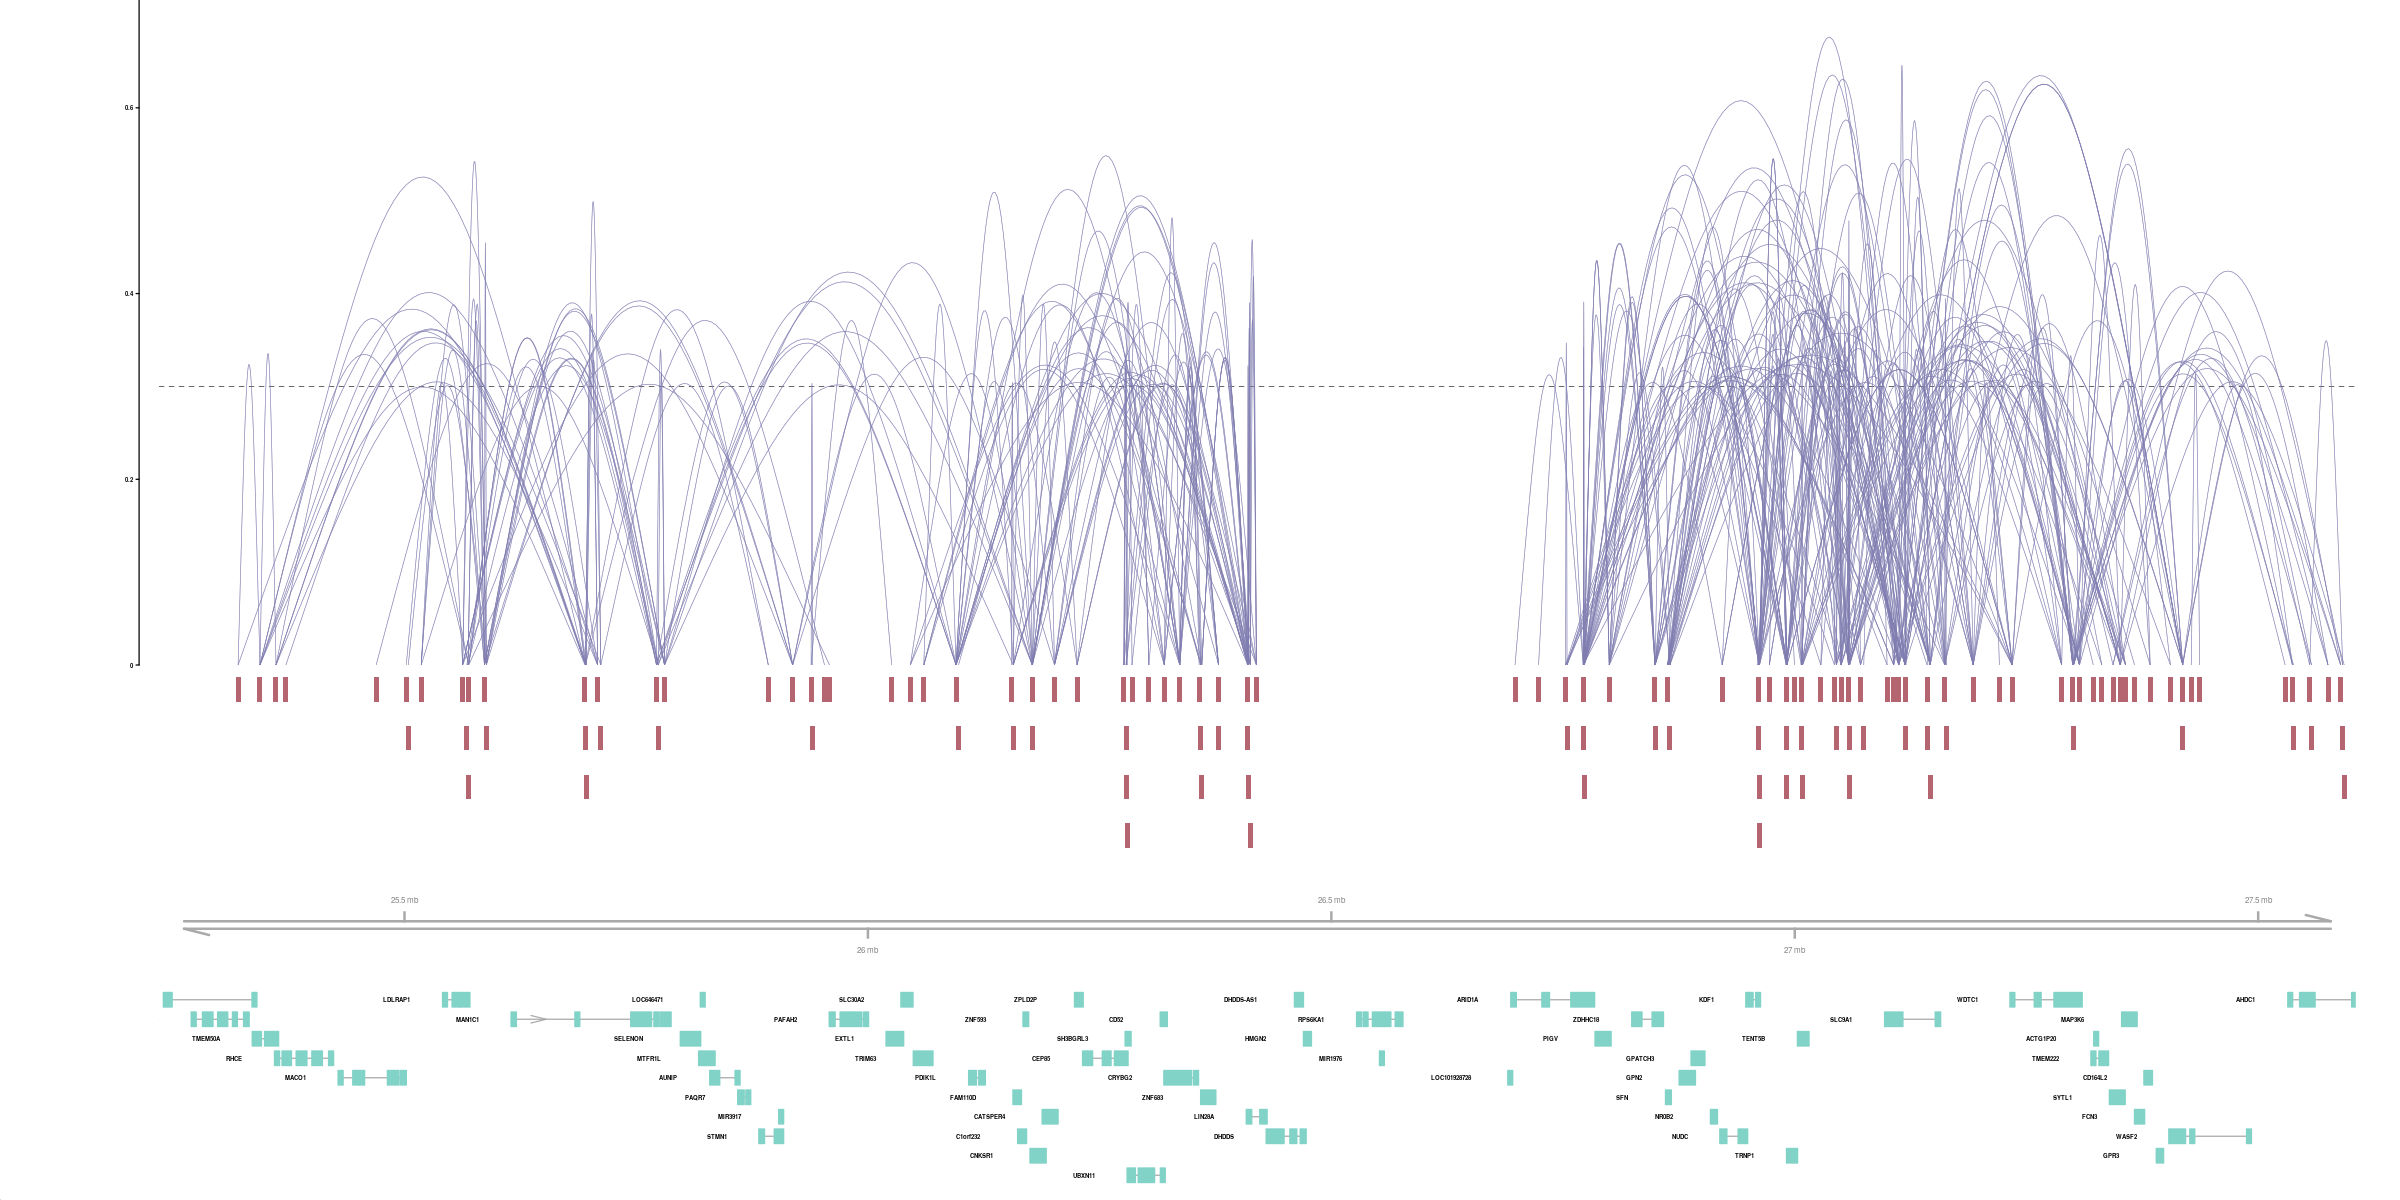

In [269]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>1000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Cis-coaccessibility Networks (CCANs)

In [345]:
CCAN_assigns <- generate_ccans(conns)

[1] "Coaccessibility cutoff used: 0.3"


In [356]:
dim(CCAN_assigns)

[1] 127104      2

In [361]:
quantile(table(CCAN_assigns$CCAN), c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

    0%    25%    50%    75%    90%    95%    99%   100% 
  3.00   3.00   3.00   6.00  23.00  43.00 105.62 377.00 

In [362]:
gz = gzfile("./out/20200417_default_20200220_n74838/ccans.thresh0.3.tsv.gz")
write.table(CCAN_assigns, file=gz, col.names=F, row.names=F, sep='\t', quote=F)